In [21]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Agents.Prio_n_step.Prio_DQN_Agent import Prio_DQN_Agent
from Agents.Pablo.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN
from Agents.Random.random_agent import RandomAgent
from Agents.utils.actions import MORE_ACTIONS
import Agents.utils.stats_functions as sf
import hockey.hockey_env as h_env

from Agents.Pablo.Agent import Dueling_DDQN_Agent
from Agents.Tapas_en_Mallorca.old.Agent import Combined_Agent
from Agents.Tapas_en_Mallorca.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN_better_mem

from importlib import reload

In [22]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 +  563 *i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [ ]:
reload(h_env)
#env_name = "../weights/prio_agent_23_02_25_n_step_4_alpha_0.4"
env_name = "../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)
#env = gym.make("CartPole-v1", render_mode = "rgb_array")

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Adaptative_Dueling_Double_DQN_better_mem(state_space, action_space, seed = seed, eps = 0.01,use_dueling = True, use_double = True, use_noisy = True, use_prio = True ,learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 4, env = env, use_more_actions = USE_MORE_ACTIONS)
#agent = Adaptative_Dueling_Double_DQN(state_space, action_space, seed = seed,use_dueling = True, use_double = True, use_noisy = True ,eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], env = env, use_more_actions = USE_MORE_ACTIONS)
#agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 4, env = env, use_more_actions = USE_MORE_ACTIONS)
agent.Q.load(env_name, name= "most_recent")

/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Dueling Network Architecture with Noisy Layers
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: NoisyLinear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling Network Architecture with Noisy Layers
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: NoisyLinear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/weights/episode_500.pth


/home/goon/studium/hockey-en-mallorca/src/hockey-env/Agents/Tapas_en_Mallorca/Adaptative_Dueling_Double_DQN/QFunction.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  se

In [24]:
stats, losses = sf.load_stats(env_name)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/returns_plot.png


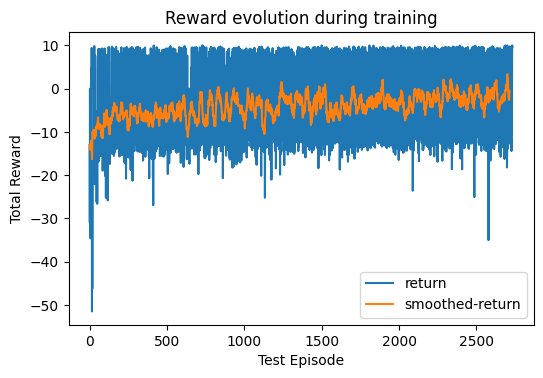

In [25]:
sf.plot_returns(stats, env_name)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/losses_plot.png


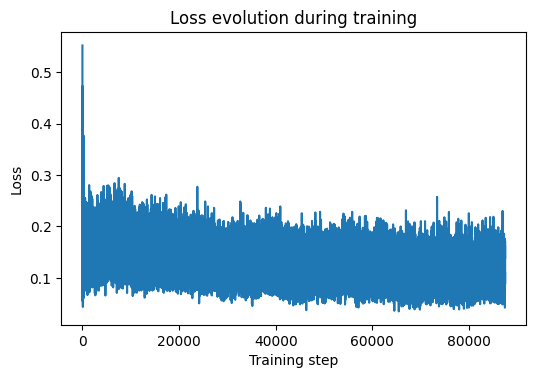

In [26]:
sf.plot_losses(losses, env_name)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/beta_evolution.png


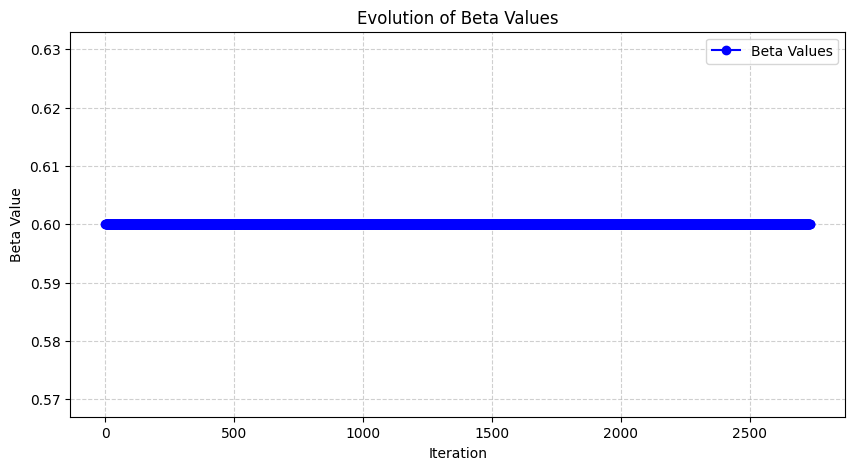

In [27]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/epsilon_evolution.png


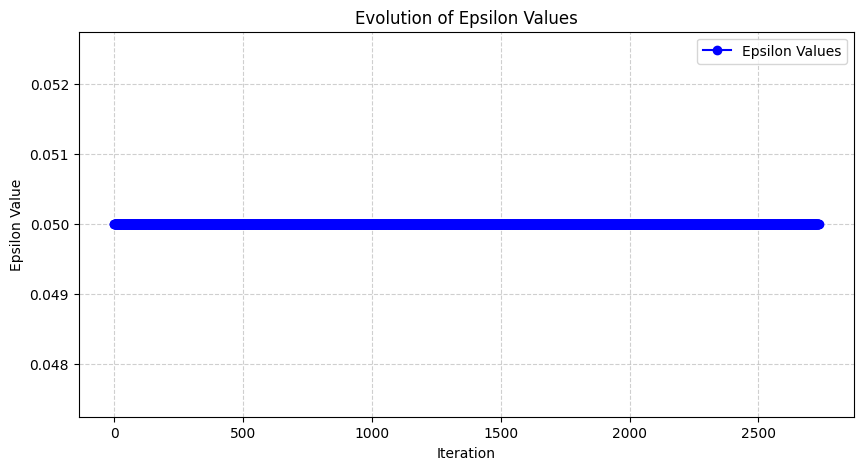

In [28]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/match_evolution.png


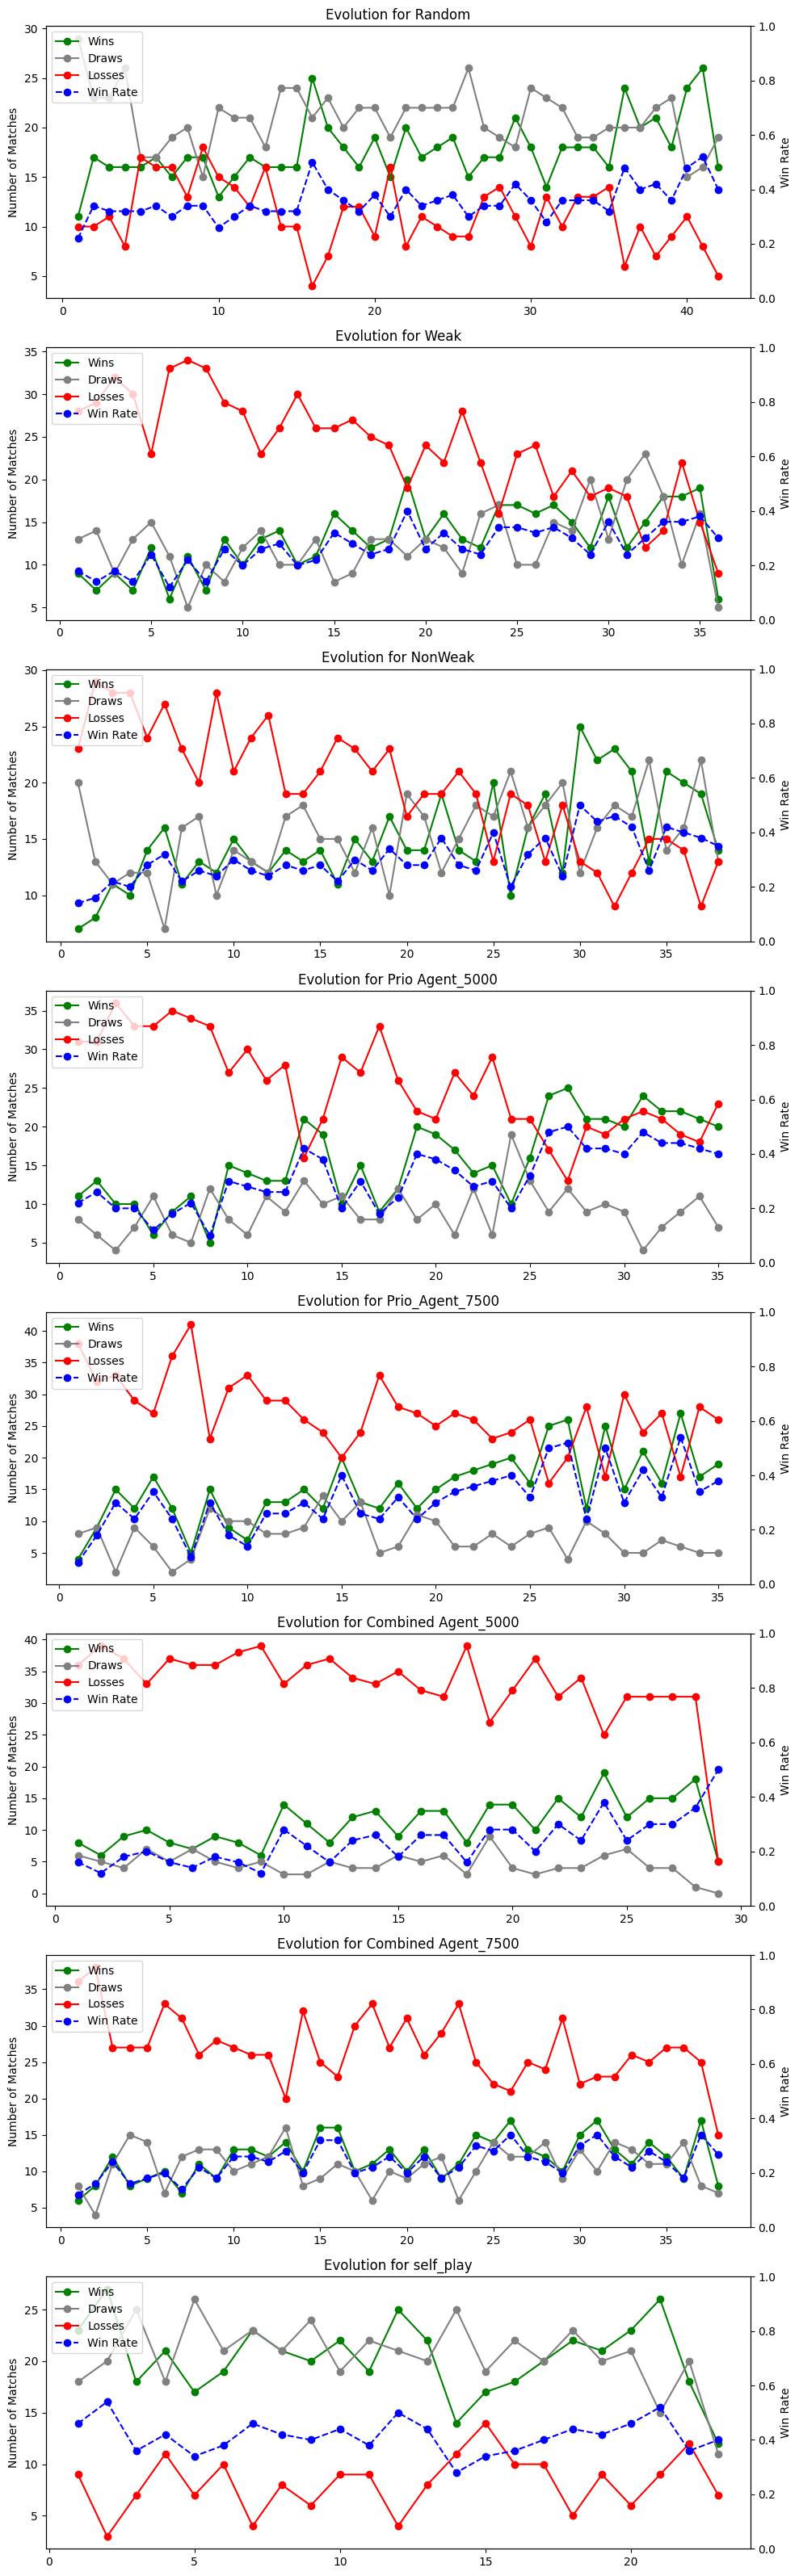

In [29]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history,  [
    "Random",
    "Weak",
    "NonWeak",
    "Prio Agent_5000",
    "Prio_Agent_7500",
    "Combined Agent_5000",
    "Combined Agent_7500",
    "self_play",
], 50)

#sf.plot_match_evolution_by_chunks(env_name, match_history,  ["Weak", "NonWeak" ],50)


In [30]:
def test_agent(agent = agent, opponent = RandomAgent(seed), test_episodes  = len(SEEDS_TEST), max_steps = 30000, opponent_name = "random", agent_name = "prio_agent", env_name = env_name):
   
    test_rewards = []
    test_name = f"{opponent_name}_vs_{agent_name}"
  
    won_games = 0
    lost_games = 0
    tied_games = 0
    for episode in range(test_episodes):

        obs_agent1, _ = env.reset(seed = SEEDS_TEST[episode])
       #state = env.reset(seed = seed)
        env.action_space.seed(seed = SEEDS_TEST[episode])
        obs_agent1= obs_agent1[0] if isinstance(obs_agent1, tuple) else obs_agent1  # Handle Gymnasium compatibility

        obs_agent2 = env.obs_agent_two()
        obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

        total_reward = 0

        frames = []
        
        for t in range(max_steps):

            done = False

            frame = env.render(mode = "rgb_array")
            if frame is not None:
                frames.append(frame)

            a1_cont = agent.get_step(obs_agent1)
            a2 = opponent.act(obs_agent2)

            full_action = np.hstack([a1_cont, a2])

            next_state, reward, done, truncated, _ = env.step(full_action)
            
            total_reward += reward

            obs_agent1 = next_state
            obs_agent2 = env.obs_agent_two()

            if done or truncated: break

        test_rewards.append(total_reward)
        won = env.winner == 1
        if won:
            won_games += 1
        tie = env.winner == 0
        if tie:
            tied_games += 1
        lost = not won and not tie
        if lost:
            lost_games += 1
        string = "Won" if won else "Tie" if tie else "Lost"
        print(f"Test Episode {episode+1}, Total Reward: {total_reward}", string)
       
        
        if frames:
            os.makedirs(f"{env_name}/test_gifs/{test_name}", exist_ok=True)
            imageio.mimsave(f"{env_name}/test_gifs/{test_name}/test_episode_{episode+1}.gif", frames, fps=30)

    env.close()
    winrate = won_games / test_episodes
    tie_rate = tied_games / test_episodes
    loss_rate = lost_games / test_episodes
    print(f"Winrate: {winrate}, Tie Rate: {tie_rate}, Loss Rate: {loss_rate}")
    results_name = f"test_results_{test_name}"
    sf.save_test_results(env_name, test_rewards, name = results_name)

Test Episode 1, Total Reward: -3.614679102777611 Tie
Test Episode 2, Total Reward: 9.61554297594388 Won
Test Episode 3, Total Reward: -10.72715573597201 Lost
Test Episode 4, Total Reward: -6.0930384911307485 Tie
Test Episode 5, Total Reward: 0.0 Tie
Test Episode 6, Total Reward: 9.266696141434332 Won
Test Episode 7, Total Reward: 0.0 Tie
Test Episode 8, Total Reward: 8.886522806037531 Won
Test Episode 9, Total Reward: 0.0 Tie
Test Episode 10, Total Reward: -12.559951577865782 Lost
Winrate: 0.3, Tie Rate: 0.5, Loss Rate: 0.2
Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/test_results_random_vs_prio_agent.png


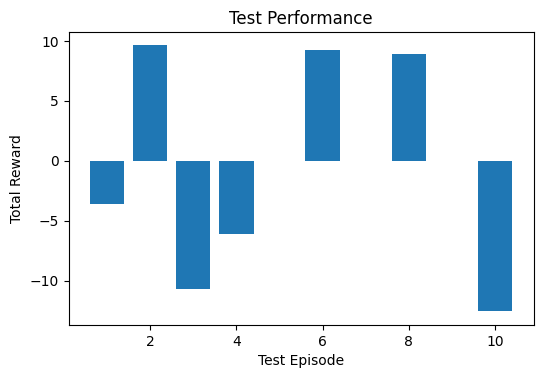

In [31]:
test_agent()

Test Episode 1, Total Reward: -10.732095897811613 Lost
Test Episode 2, Total Reward: 9.63746768571188 Won
Test Episode 3, Total Reward: -11.05675994221577 Lost
Test Episode 4, Total Reward: 9.024298388538833 Won
Test Episode 5, Total Reward: 9.896553002459179 Won
Test Episode 6, Total Reward: -12.120949967867391 Lost
Test Episode 7, Total Reward: -12.864167907533306 Lost
Test Episode 8, Total Reward: -15.530646267912166 Lost
Test Episode 9, Total Reward: 8.68159923109092 Won
Test Episode 10, Total Reward: 8.601861764828122 Won
Winrate: 0.5, Tie Rate: 0.0, Loss Rate: 0.5
Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/test_results_weak_vs_prio_agent.png


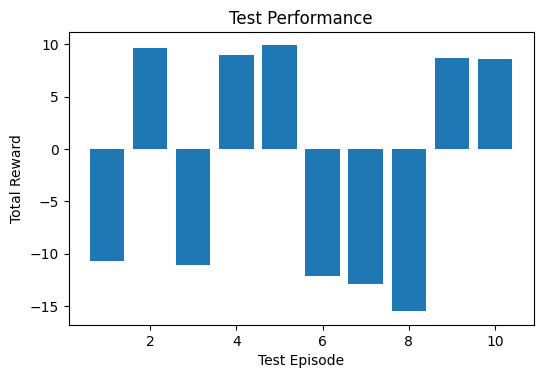

In [32]:
test_agent(opponent = h_env.BasicOpponent(weak=True), opponent_name = "weak", agent_name = "prio_agent")



Test Episode 1, Total Reward: -6.103745842341237 Tie
Test Episode 2, Total Reward: -12.619765653146235 Lost
Test Episode 3, Total Reward: -3.785789682914853 Won
Test Episode 4, Total Reward: -7.500102675967141 Tie
Test Episode 5, Total Reward: 8.94301814852242 Won
Test Episode 6, Total Reward: -12.73413019801269 Lost
Test Episode 7, Total Reward: -3.500026172074823 Tie
Test Episode 8, Total Reward: -6.055805841801489 Tie
Test Episode 9, Total Reward: -19.361172155477817 Tie
Test Episode 10, Total Reward: 7.304098191018195 Won
Winrate: 0.3, Tie Rate: 0.5, Loss Rate: 0.2
Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/test_results_non_weak_vs_prio_agent.png


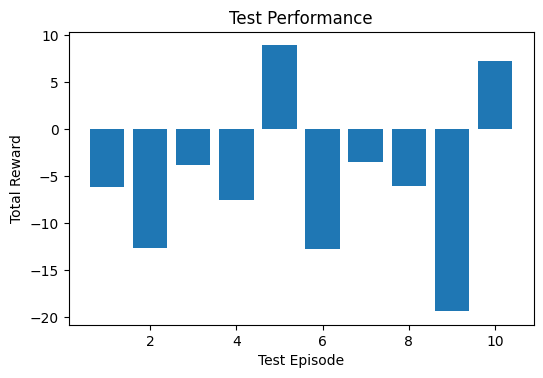

In [33]:
test_agent(opponent = h_env.BasicOpponent(weak=False), opponent_name = "non_weak", agent_name = "prio_agent")

Test Episode 1, Total Reward: -10.698261664727807
Test Episode 2, Total Reward: 9.604309925033592
Test Episode 3, Total Reward: -1.0589157589387856
Test Episode 4, Total Reward: 8.878826035067997
Test Episode 5, Total Reward: -5.830559083278873
Test Episode 6, Total Reward: -15.316758310280083
Test Episode 7, Total Reward: -14.03440026700708
Test Episode 8, Total Reward: -6.934665615288128
Test Episode 9, Total Reward: -16.209469463591127
Test Episode 10, Total Reward: -13.874021815872636
Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only/stats/plots/test_results_selfplay.png


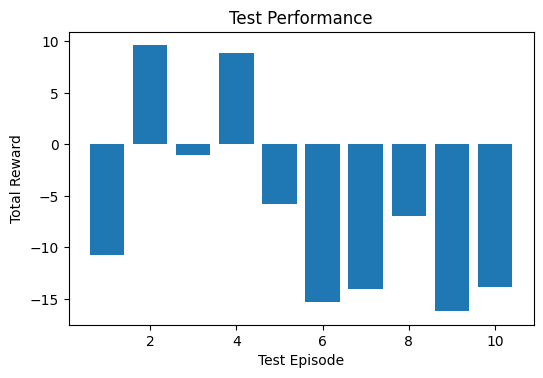

In [34]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)
#opponent.Q.load(env_name, name = "episode_1500")

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    env.action_space.seed(seed)
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.act(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")